## 빅데이터 활용 AI 설계
# AutoEncoder
- https://blog.keras.io/building-autoencoders-in-keras.html

<img src='https://www.researchgate.net/profile/Xifeng_Guo/publication/320658590/figure/fig1/AS:614154637418504@1523437284408/The-structure-of-proposed-Convolutional-AutoEncoders-CAE-for-MNIST-In-the-middle-there.png' />
(출처: https://www.researchgate.net/figure/The-structure-of-proposed-Convolutional-AutoEncoders-CAE-for-MNIST-In-the-middle-there_fig1_320658590)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### MNIST 로딩

In [16]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [17]:
X_train = X_train.reshape(-1,28,28,1)/255
X_test = X_test.reshape(-1,28,28,1)/255

X_train.shape, X_test.shape, X_train[0].max(), X_train[0].dtype

((60000, 28, 28, 1), (10000, 28, 28, 1), 1.0, dtype('float64'))

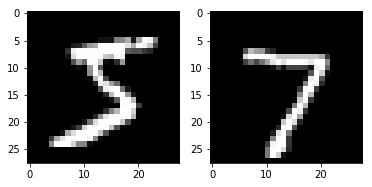

In [19]:
plt.subplot(1,2,1)
plt.imshow(X_train[0].reshape(28,28), cmap='gray')
#plt.imshow(X_train[0,:,:,0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(X_test[0].reshape(28,28), cmap='gray')

### 인코더 생성

In [5]:
from keras.models import Model
from keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose

In [6]:
input = Input((28,28,1))

x = Conv2D(32, (3,3), strides=2, padding='same', activation='relu')(input)
x = Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = Conv2D(128, (3,3), strides=2, activation='relu')(x)

x = Flatten()(x)
latent = Dense(10)(x)

- 인코더의 출력은 10개의 벡터값이다.
- 이 값을 잠재공간벡터(latent vector) 라고 한다.
- 즉, 28\*28\*1 의 이미지를 10개의 숫자로 축약하였다.

In [10]:
encoder = Model(input, latent)

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                11530     
Total params: 104,202
Trainable params: 104,202
Non-trainable params: 0
_________________________________________________________________


### 디코더 생성

In [11]:
input2 = Input((10,))

x2 = Dense(3*3*128, activation='relu')(input2)
x2 = Reshape((3,3,128))(x2)

x2 = Conv2DTranspose(64, (3,3), strides=2, activation='relu')(x2)
x2 = Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')(x2)

output = Conv2DTranspose(1, (3,3), strides=2, padding='same', activation='relu')(x2)

- Conv2DTranspose 설명 : https://datascience.stackexchange.com/questions/6107/what-are-deconvolutional-layers
<img src='https://i.stack.imgur.com/YyCu2.gif' />
<img src='https://i.stack.imgur.com/f2RiP.gif' />

In [12]:
decoder = Model(input2, output)

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1152)              12672     
_________________________________________________________________
reshape_1 (Reshape)          (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 7, 7, 64)          73792     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 105,217
Trainable params: 105,217
Non-trainable params: 0
_________________________________________________________________


### 오토인코더 구성

In [13]:
autoencoder = Model(input, decoder(encoder(input)))

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_3 (Model)              (None, 10)                104202    
_________________________________________________________________
model_4 (Model)              (None, 28, 28, 1)         105217    
Total params: 209,419
Trainable params: 209,419
Non-trainable params: 0
_________________________________________________________________


In [14]:
autoencoder.compile(loss='mse', optimizer='rmsprop', metrics=['acc'])

In [20]:
autoencoder.fit(X_train, X_train, batch_size=32,
                epochs=1, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 228s 4ms/step - loss: 0.0267 - acc: 0.8079 - val_loss: 0.0181 - val_acc: 0.8077


### 평가

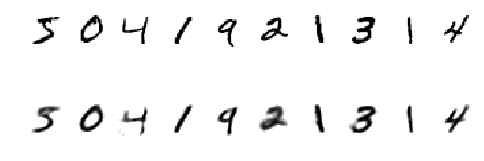

In [22]:
plt.figure(figsize=[8,3])

for i in range(10):
    r = autoencoder.predict(X_train[[i]])

    plt.subplot(2,10,1+i)
    plt.imshow(X_train[i,:,:,0], vmax=1, vmin=0, cmap='gray_r')
    plt.axis('off')

    plt.subplot(2,10,11+i)
    plt.imshow(r[0,:,:,0], vmax=1, vmin=0, cmap='gray_r')
    plt.axis('off')

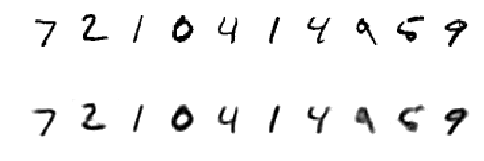

In [21]:
plt.figure(figsize=[8,3])

for i in range(10):
    r = autoencoder.predict(X_test[[i]])

    plt.subplot(2,10,1+i)
    plt.imshow(X_test[i,:,:,0], vmax=1, vmin=0, cmap='gray_r')
    plt.axis('off')

    plt.subplot(2,10,11+i)
    plt.imshow(r[0,:,:,0], vmax=1, vmin=0, cmap='gray_r')
    plt.axis('off')

### 시각화
- 잠재공간 10차원 중 앞 2차원을 활용

In [23]:
latent_value = encoder.predict(X_train)

In [24]:
latent_value.shape

(60000, 10)

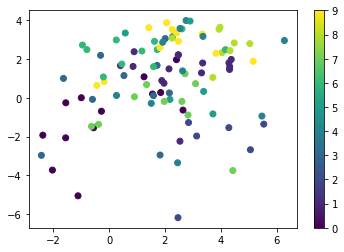

In [25]:
plt.scatter(latent_value[:100,0], latent_value[:100,1], c=y_train[:100])
plt.colorbar()

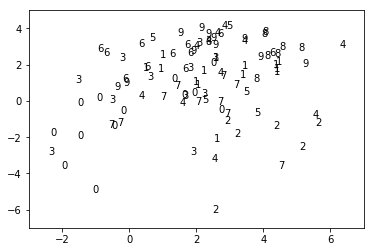

In [27]:
plt.axis([-3,7,-7,5])
for i in range(100):
    plt.text(latent_value[i,0], latent_value[i,1], str(y_train[i]))

### 도전과제
- 잠재공간이 2차원인 인코더를 만들자.
- 학습을 시킨 후, 테스트 데이터에 대한 2차원 산점도를 그려보자. (각 점은 해당 숫자로 표시)